## Attention is all you need
This notebook was run on kaggle. You can run it there. It is important to run the first code block before everything else. It is inspired by the following links:

https://www.kaggle.com/code/latinchakma/transformer-based-seq2seq-de-to-en-multi30k

https://www.kaggle.com/code/qinyukun/attention-is-all-you-need

Most of the codes are derived from those notebooks, but because of some changes to newer libraries, none of them worked correctly. So, I made some changes to make it work.

## Importing Libraries

In [2]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm
!pip install 'portalocker>=2.0.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 77.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 83.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_context(context="talk")
%matplotlib inline

import math, copy
import spacy
import torchtext
from torchtext.datasets import Multi30k, multi30k
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

import os, random, time, importlib
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)



## Defining the Transformer Model
### Part a:
The model should consist of an encoder and a decoder, each composed of multiple layers
of self-attention and feed-forward networks. You should also implement the positional
encoding, the scaled dot-product attention, and the multi-head attention mechanisms. 

In [4]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, 
        n_layers, n_heads, pf_dim, 
        dropout, max_length=100
    ):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)
        self.layers = nn.ModuleList(
            [EncoderLayer(hidden_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)]
        )
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
    
    def forward(self, src, src_mask):
        # src = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # pos = [batch_size, src_len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(device)
        
        # src = [batch_size, src_len, hidden_dim]
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        # src = [batch_size, src_len, hidden_dim]
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src


In [5]:
class EncoderLayer(nn.Module):
    def __init__(
        self, hidden_dim, n_heads, 
        pf_dim, dropout
    ):
        super(EncoderLayer, self).__init__()
        
        # Layernorm forces certain channels of batch data to mu=0, sigma=1
        self.attention_norm = nn.LayerNorm(hidden_dim)
        self.feed_forward_norm = nn.LayerNorm(hidden_dim)
        
        self.self_attention_layer = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout)
        self.positionwise_feedforward_layer = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # src = [batch_size, seq_len, hidden_dim]
        # src_mask = [batch_size, 1, 1, src_len]
        
        # src = [batch_size, src_len, hidden_dim]
        _src, _ = self.self_attention_layer(src, src, src, src_mask)
        src = self.attention_norm(src + self.dropout(_src))
        
        # src = [batch_size, src_len, hidden_dim]
        _src = self.positionwise_feedforward_layer(src)
        src = self.feed_forward_norm(src + self.dropout(_src))
        
        return src


In [6]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout):
        super(MultiHeadAttentionLayer, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads
        
        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)
        
        self.fc_o = nn.Linear(hidden_dim, hidden_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        # Q = [batch size, n_heads, query len, hid dim]
        # K = [batch size, n_heads, key len, hid dim]
        # V = [batch size, n_heads, value len, hid dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        # energy = [batch size, n heads, query len, key len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # attention = [batch size, n heads, query len, key len]
        attention = torch.softmax(energy, dim=-1)
        
        # One thing that looks strange at first is that dropout 
        # is applied directly to the attention. This means that 
        # our attention vector will most probably not sum to 1 
        # and we may pay full attention to a token but the attention 
        # over that token is set to 0 by dropout. 
        # x = [batch size, n heads, query len, head dim]
        x = torch.matmul(self.dropout(attention), V)
        
        # x = [batch size, query len, n heads, head_dim]
        x = x.permute(0, 2, 1, 3).contiguous()
        
        # x = [batch size, query len, hidden_dim]
        x = x.view(batch_size, -1, self.hidden_dim)
        
        # x = [batch size, query len, hid dim]
        x = self.fc_o(x)
        
        return x, attention


In [7]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout):
        super(PositionwiseFeedforwardLayer, self).__init__()
        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x = [batch_size, seq_len, pf_dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        # x = [batch_size, seq_len, hidden_dim]
        x = self.fc_2(x)
        
        return x


In [8]:
class Decoder(nn.Module):
    def __init__(
        self, output_dim, hidden_dim, 
        n_layers, n_heads, pf_dim, 
        dropout, max_length=100
    ):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)
        
        self.layers = nn.ModuleList(
            [DecoderLayer(hidden_dim, n_heads, pf_dim, dropout) for _ in range(n_layers)]
        )
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(device)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        output = self.fc_out(trg)
        return output, attention


In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attention_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attention_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        
        self.self_attention_layer = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout)
        self.positionwise_feedforward_layer = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #trg = [batch size, trg len, hid dim]
        _trg, _ = self.self_attention_layer(trg, trg, trg, trg_mask)
        trg = self.self_attention_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attention_layer_norm(trg + self.dropout(_trg))
        
        _trg = self.positionwise_feedforward_layer(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention


In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
    
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask
    
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        return output, attention


## Reading Data and Initialization

In [11]:
def is_torch_available():
    # PyTorch installed
    return importlib.util.find_spec("torch") is not None

def init_seed(seed=0):
    # Intitialize random number generator (RNG) seeds
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

init_seed()

In [12]:
# We need to modify the URLs for the dataset since the links to the original dataset are broken
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

# Create source and target language tokenizer.
token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer("spacy", language='en_core_web_sm')

In [13]:
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE:0, TGT_LANGUAGE:1}
    
    for sample in data_iter:
        yield token_transform[language](sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=[SRC_LANGUAGE, TGT_LANGUAGE])
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_iter, ln), 
        min_freq=1, 
        specials=special_symbols, 
        special_first=True
    )

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)


In [14]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE].vocab)
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE].vocab)
HIDDEN_DIM = 256
ENCODER_LAYERS = 3
DECODER_LAYERS = 3
ENCODER_HEADS = 8
DECODER_HEADS = 8
ENCODER_PF_DIM = 512
DECODER_PF_DIM = 512
ENCODER_DROPOUT = 0.1
DECODER_DROPOUT = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
NUM_EPOCHS = 20
NUM_WORKERS = 4
PIN_MEMORY = device.type != "cpu"
DROP_LAST = False
GRAD_NORM = 1.0



In [15]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, ENCODER_LAYERS, ENCODER_HEADS, ENCODER_PF_DIM, ENCODER_DROPOUT)
decoder = Decoder(OUTPUT_DIM, HIDDEN_DIM, DECODER_LAYERS, DECODER_HEADS, DECODER_PF_DIM, DECODER_DROPOUT)
transformer = Seq2Seq(encoder, decoder, PAD_IDX, PAD_IDX).to(device)


In [16]:
# transformer

In [17]:
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
# num parameters
n_p = sum(x.numel() for x in transformer.parameters())
# num gradients
n_g = sum(x.numel() for x in transformer.parameters() if x.requires_grad)
# model size
param_size = 0
for param in transformer.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in transformer.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
size = (param_size + buffer_size) / 1024**2
# model name
name = type(transformer).__name__

print(f"{name} summary: {len(list(transformer.modules()))} layers, {n_p} parameters, {n_g} gradients, {size:.2f}MB memory")

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, verbose=True)


Seq2Seq summary: 117 layers, 14483029 parameters, 14483029 gradients, 55.25MB memory
Adjusting learning rate of group 0 to 5.0000e-04.


In [18]:
amp_dtype = torch.float16
scaler = torch.cuda.amp.GradScaler()
autocast_context_manager = torch.cuda.amp.autocast(enabled=True, dtype=amp_dtype)


In [19]:
def sequential_transforms(*transforms):
    def func(text_input):
        for transform in transforms:
            text_input = transform(text_input)
        return text_input
    return func

def tensor_transform(token_ids):
    return torch.cat((
        torch.tensor([BOS_IDX]),
        torch.tensor(token_ids),
        torch.tensor([EOS_IDX])
    ))

text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln], # tokenization
        vocab_transform[ln], # numericalization
        tensor_transform # append bos and eos tokens
    )
    
def collate_fn(batch):
    src_batch, tgt_batch = [[] for _ in range(2)]
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

## Training
### Part b:
You should monitor the training loss and the validation loss, and save the best model
based on the validation loss.

In [20]:
def train_epoch():
    epoch_loss = 0
    steps_in_current_epoch = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_loader = DataLoader(
        train_iter, batch_size=BATCH_SIZE,
        pin_memory=PIN_MEMORY, 
        drop_last=DROP_LAST, collate_fn=collate_fn
    )
    
    for src, tgt in tqdm(train_loader, position=0, desc="Training"):
        transformer.train()
        
        src = src.to(device).long().permute(1, 0)
        tgt = tgt.to(device).long().permute(1, 0)
        
        with torch.set_grad_enabled(True):
            with autocast_context_manager:
                output, _ = transformer(src, tgt[:, :-1])
                loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        
        scaler.scale(loss).backward()
        
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), GRAD_NORM)
        
        scaler.step(optimizer)
        scaler.update()
        
        transformer.zero_grad()
        
        epoch_loss += loss.item()
        steps_in_current_epoch += 1
        
    return epoch_loss / steps_in_current_epoch


In [21]:
def evaluate():
    epoch_loss = 0
    steps_in_current_epoch = 0
    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_loader = DataLoader(
        val_iter, batch_size=BATCH_SIZE, 
        pin_memory=PIN_MEMORY, 
        drop_last=DROP_LAST, collate_fn=collate_fn
    )
    
    for src, tgt in tqdm(val_loader, position=0, desc="Evaluating"):
        transformer.eval()
        
        src = src.to(device).long().permute(1, 0)
        tgt = tgt.to(device).long().permute(1, 0)
        
        with torch.set_grad_enabled(False):
            output, _ = transformer(src, tgt[:, :-1])
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        
        epoch_loss += loss.item()
        steps_in_current_epoch += 1
        
    return epoch_loss / steps_in_current_epoch


In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [23]:
# Initialize lists to store loss and perplexity values
train_losses = []
train_ppls = []
valid_losses = []
valid_ppls = []

best_valid_loss = float("inf")
transformer.zero_grad()

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch()
    valid_loss = evaluate()

    scheduler.step()

    end_time = time.time()

    epoch_mins, epoch_secs = divmod(int(end_time - start_time), 60)

    # Append values for plotting
    train_losses.append(train_loss)
    train_ppls.append(math.exp(train_loss))
    valid_losses.append(valid_loss)
    valid_ppls.append(math.exp(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(transformer.state_dict(), 'transformer-model.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')



Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.9692e-04.
Epoch: 01 | Time: 0m 20s
	Train Loss: 4.518 | Train PPL:  91.651
	 Val. Loss: 3.373 |  Val. PPL:  29.169


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.8776e-04.
Epoch: 02 | Time: 0m 18s
	Train Loss: 2.983 | Train PPL:  19.745
	 Val. Loss: 2.672 |  Val. PPL:  14.465


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7275e-04.
Epoch: 03 | Time: 0m 18s
	Train Loss: 2.367 | Train PPL:  10.667
	 Val. Loss: 2.372 |  Val. PPL:  10.714


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.5225e-04.
Epoch: 04 | Time: 0m 18s
	Train Loss: 1.982 | Train PPL:   7.255
	 Val. Loss: 2.216 |  Val. PPL:   9.173


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.2678e-04.
Epoch: 05 | Time: 0m 18s
	Train Loss: 1.707 | Train PPL:   5.513
	 Val. Loss: 2.115 |  Val. PPL:   8.292


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.9695e-04.
Epoch: 06 | Time: 0m 18s
	Train Loss: 1.495 | Train PPL:   4.459
	 Val. Loss: 2.078 |  Val. PPL:   7.987


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.6350e-04.
Epoch: 07 | Time: 0m 18s
	Train Loss: 1.318 | Train PPL:   3.736
	 Val. Loss: 2.047 |  Val. PPL:   7.744


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.2725e-04.
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.167 | Train PPL:   3.213
	 Val. Loss: 2.037 |  Val. PPL:   7.666


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.8911e-04.
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.041 | Train PPL:   2.831
	 Val. Loss: 2.057 |  Val. PPL:   7.824


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10 | Time: 0m 18s
	Train Loss: 0.929 | Train PPL:   2.532
	 Val. Loss: 2.053 |  Val. PPL:   7.789


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.1089e-04.
Epoch: 11 | Time: 0m 18s
	Train Loss: 0.834 | Train PPL:   2.302
	 Val. Loss: 2.071 |  Val. PPL:   7.935


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.7275e-04.
Epoch: 12 | Time: 0m 18s
	Train Loss: 0.753 | Train PPL:   2.122
	 Val. Loss: 2.083 |  Val. PPL:   8.027


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.3650e-04.
Epoch: 13 | Time: 0m 18s
	Train Loss: 0.679 | Train PPL:   1.973
	 Val. Loss: 2.095 |  Val. PPL:   8.129


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0305e-04.
Epoch: 14 | Time: 0m 18s
	Train Loss: 0.620 | Train PPL:   1.859
	 Val. Loss: 2.111 |  Val. PPL:   8.259


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 7.3223e-05.
Epoch: 15 | Time: 0m 18s
	Train Loss: 0.573 | Train PPL:   1.773
	 Val. Loss: 2.115 |  Val. PPL:   8.294


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7746e-05.
Epoch: 16 | Time: 0m 18s
	Train Loss: 0.533 | Train PPL:   1.705
	 Val. Loss: 2.128 |  Val. PPL:   8.400


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.7248e-05.
Epoch: 17 | Time: 0m 18s
	Train Loss: 0.509 | Train PPL:   1.663
	 Val. Loss: 2.137 |  Val. PPL:   8.472


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.2236e-05.
Epoch: 18 | Time: 0m 18s
	Train Loss: 0.488 | Train PPL:   1.628
	 Val. Loss: 2.142 |  Val. PPL:   8.513


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0779e-06.
Epoch: 19 | Time: 0m 18s
	Train Loss: 0.476 | Train PPL:   1.609
	 Val. Loss: 2.145 |  Val. PPL:   8.538


Training: 0it [00:00, ?it/s]

Evaluating: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 0.0000e+00.
Epoch: 20 | Time: 0m 18s
	Train Loss: 0.470 | Train PPL:   1.601
	 Val. Loss: 2.142 |  Val. PPL:   8.516


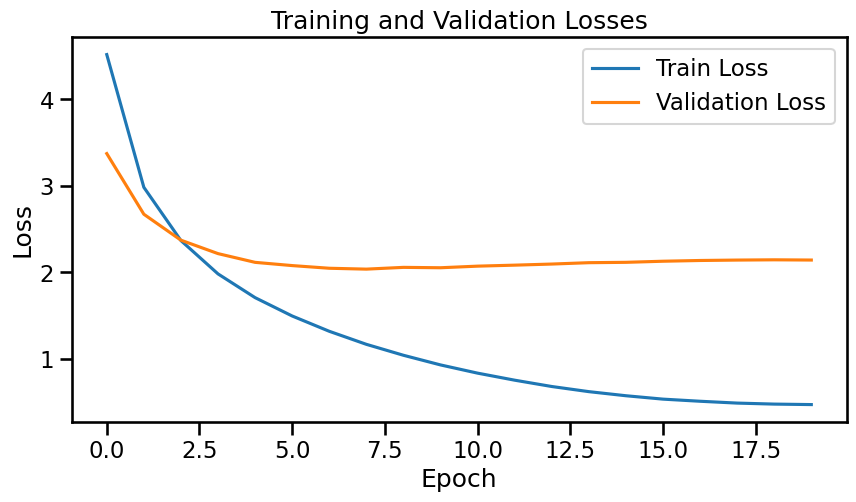

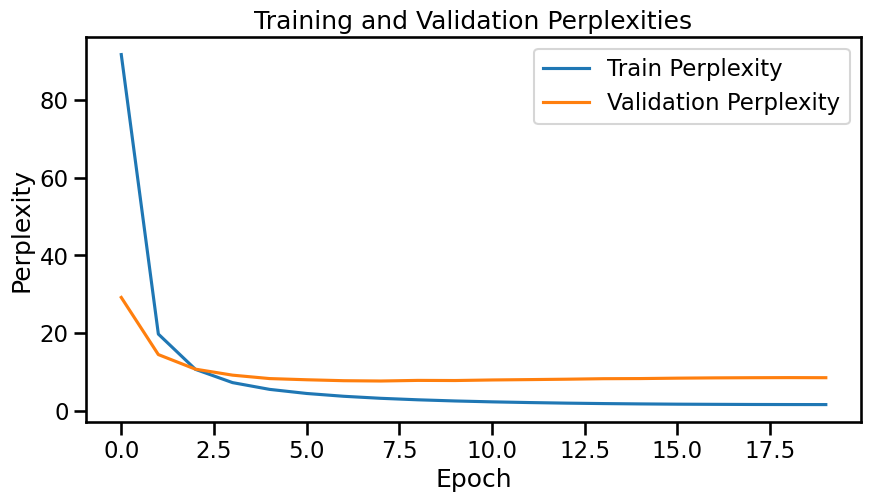

In [24]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_ppls, label='Train Perplexity')
plt.plot(valid_ppls, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexities')
plt.legend()
plt.show()


In [29]:
def evaluate_test():
    epoch_loss = 0
    steps_in_current_epoch = 0
    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_loader = DataLoader(
        val_iter, batch_size=BATCH_SIZE, 
        pin_memory=PIN_MEMORY, 
        drop_last=DROP_LAST, collate_fn=collate_fn
    )
    
    for src, tgt in tqdm(val_loader, position=0, desc="Evaluating"):
        transformer.eval()
        
        src = src.to(device).long().permute(1, 0)
        tgt = tgt.to(device).long().permute(1, 0)
        
        with torch.set_grad_enabled(False):
            output, _ = transformer(src, tgt[:, :-1])
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))
        
        epoch_loss += loss.item()
        steps_in_current_epoch += 1
        
    return epoch_loss / steps_in_current_epoch


In [25]:
transformer.load_state_dict(torch.load('/kaggle/working/transformer-model.pt'))


<All keys matched successfully>

In [30]:
test_loss = evaluate_test()
print(f'\t Test Loss: {test_loss:.3f} |  Test PPL: {math.exp(test_loss):7.3f}')



Evaluating: 0it [00:00, ?it/s]

	 Test Loss: 2.037 |  Test PPL:   7.666


## Inference

In [31]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = tokens + ['<eos>']

    src_indexes = [src_vocab[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_vocab['<sos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes]

    return trg_tokens[1:], attention


In [39]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
tokenizer_src = get_tokenizer('spacy', language=SRC_LANGUAGE)
tokenizer_tgt = get_tokenizer('spacy', language=TGT_LANGUAGE)

example_idx = 9
# Iterate through the examples to find the desired one
for idx, example in enumerate(train_iter):
    if idx == example_idx:
        # Tokenize source and target sequences
        src_sequence = tokenizer_src(example[0])
        tgt_sequence = tokenizer_tgt(example[1])
        
        print(f'src = {src_sequence}')
        print(f'trg = {tgt_sequence}')
        break


src = ['Jungen', 'tanzen', 'mitten', 'in', 'der', 'Nacht', 'auf', 'Pfosten', '.']
trg = ['Boys', 'dancing', 'on', 'poles', 'in', 'the', 'middle', 'of', 'the', 'night', '.']


In [40]:
src_vocab = vocab_transform[SRC_LANGUAGE]
trg_vocab = vocab_transform[TGT_LANGUAGE]

In [41]:
translation, attention = translate_sentence(src_sequence, src_vocab, trg_vocab, transformer, device, max_len=50)


In [42]:
print(f'predicted trg = {translation}')


predicted trg = ['young', 'boys', 'in', 'the', 'middle', 'of', 'the', 'class', '.', '<eos>']


## Displaying Attention
### Part c:
You should also plot the attention maps of the decoder block, and interpret the results:

The following plots, are attention maps from the 8 attention heads.

The source sentence means boys dancing on poles in the middle of the night. the model translated it: young boys in the middle of the class. we can see that the model is capable of producing meaningful english, but is lacking the power to translate perfectly.

In the attention maps, we can see that 'jungen' mostly attends to 'boys', which is the correct meaning. 
The <sos> token usually pays attention to young which is the first word of the sentence, which is natural.
Some words are attending to the wrong meaning. This can be solved by training the model on more epochs.

In [43]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

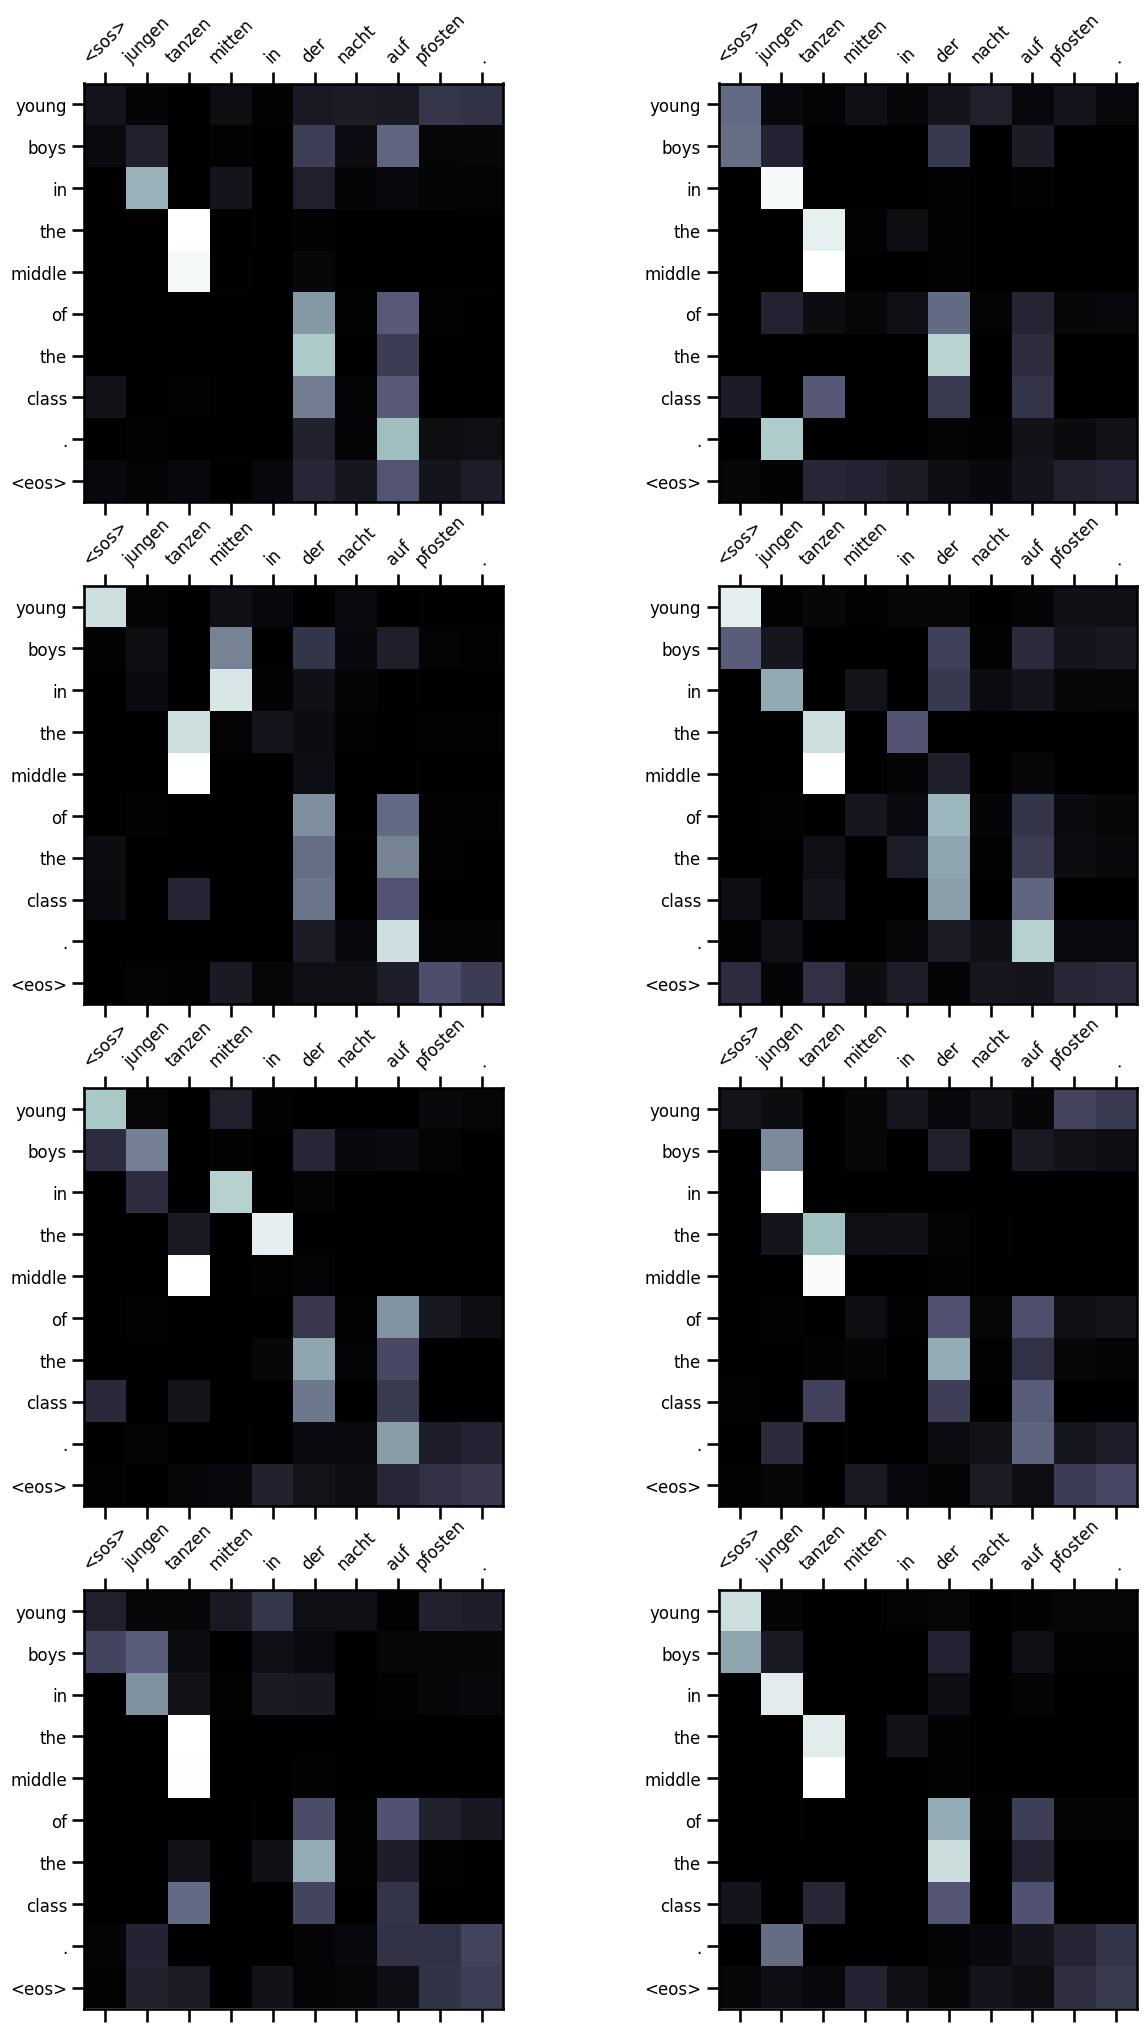

In [44]:
display_attention(src_sequence, translation, attention)


## BLEU Score
### Pard d:
evaluate the performance of the decoder block on a test set of sentence pairs, and to
report the metrics, such as the accuracy, the loss, and the BLEU score. (Val Loss and Perplexity can be seen above)

In [46]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(translate_func, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    src_vocab = vocab_transform[SRC_LANGUAGE]
    trg_vocab = vocab_transform[TGT_LANGUAGE]
    for idx, example in enumerate(train_iter):
        src_sequence = tokenizer_src(example[0])
        trg_sequence = tokenizer_tgt(example[1])
        pred_trg, _ = translate_func(src_sequence, src_vocab, trg_vocab, model, device, max_len=50)

        # Cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg_sequence])
        if idx == 100:
            break
    return bleu_score(pred_trgs, trgs)


In [47]:
bleu_score = calculate_bleu(translate_sentence, transformer, device)

print(f'BLEU score = {bleu_score*100:.2f}')


BLEU score = 8.31
